<a href="https://colab.research.google.com/github/sthalles/SimCLR/blob/master/feature_eval/linear_feature_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown

In [2]:
folder_name = 'resnet-18_80-epochs'

# !gdown https://drive.google.com/uc?id=1c4eVon0sUd-ChVhH6XMpF6nCngNJsAPk # ResNet 18 --> 40 epochs trained
!gdown https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT # ResNet 18 --> 80 epochs trained
!unzip resnet-18_80-epochs
!ls

Downloading...
From: https://drive.google.com/uc?id=1L0yoeY9i2mzDcj69P4slTWb-cfr3PyoT
To: /media/joshua/Milano/Milano_git_work_zone/SelfSupervisedLearning_PyTorch/SimCLR/src/feature_eval/resnet-18_80-epochs.zip
100%|██████████████████████████████████████| 43.3M/43.3M [00:00<00:00, 80.0MB/s]
Archive:  resnet-18_80-epochs.zip
   creating: resnet-18_80-epochs/
   creating: resnet-18_80-epochs/checkpoints/
  inflating: resnet-18_80-epochs/checkpoints/config.yaml  
  inflating: resnet-18_80-epochs/checkpoints/model.pth  
  inflating: resnet-18_80-epochs/checkpoints/resnet_simclr.py  
  inflating: resnet-18_80-epochs/events.out.tfevents.1584175972.thallessilva.7272.0  
linear_feature_eval.ipynb			resnet-18_80-epochs
mini_batch_logistic_regression_evaluator.ipynb	resnet-18_80-epochs.zip


In [3]:
!ls

linear_feature_eval.ipynb			resnet-18_80-epochs
mini_batch_logistic_regression_evaluator.ipynb	resnet-18_80-epochs.zip


In [4]:
# download and extract stl10
!wget http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
!tar -zxvf stl10_binary.tar.gz
!ls

--2022-02-09 11:49:30--  http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2640397119 (2.5G) [application/x-gzip]
Saving to: ‘stl10_binary.tar.gz’

stl10_binary.tar.gz 100%[===================>]   2.46G  31.5MB/s    in 76s     

2022-02-09 11:50:46 (33.2 MB/s) - ‘stl10_binary.tar.gz’ saved [2640397119/2640397119]

stl10_binary/
stl10_binary/test_X.bin
stl10_binary/test_y.bin
stl10_binary/train_X.bin
stl10_binary/train_y.bin
stl10_binary/unlabeled_X.bin
stl10_binary/class_names.txt
stl10_binary/fold_indices.txt
linear_feature_eval.ipynb			resnet-18_80-epochs.zip
mini_batch_logistic_regression_evaluator.ipynb	stl10_binary
resnet-18_80-epochs				stl10_binary.tar.gz


In [5]:
import torch
import sys
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
import yaml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import importlib.util

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


In [7]:
checkpoints_folder = os.path.join(folder_name, 'checkpoints')
config = yaml.load(open(os.path.join(checkpoints_folder, "config.yaml"), "r"))
config

/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'batch_size': 512,
 'epochs': 40,
 'eval_every_n_epochs': 1,
 'fine_tune_from': 'Mar13_22-46-30_thallessilva',
 'log_every_n_steps': 50,
 'model': {'out_dim': 256, 'base_model': 'resnet18'},
 'dataset': {'s': 1,
  'input_shape': '(96,96,3)',
  'num_workers': 0,
  'valid_size': 0.05},
 'loss': {'temperature': 0.5, 'use_cosine_similarity': True}}

In [8]:
checkpoints_folder

'resnet-18_80-epochs/checkpoints'

In [9]:
def _load_stl10(prefix="train"):
    X_train = np.fromfile('./stl10_binary/' + prefix + '_X.bin', dtype=np.uint8)
    y_train = np.fromfile('./stl10_binary/' + prefix + '_y.bin', dtype=np.uint8)

    X_train = np.reshape(X_train, (-1, 3, 96, 96)) # CWH
    X_train = np.transpose(X_train, (0, 1, 3, 2)) # CHW

    print("{} images".format(prefix))
    print(X_train.shape)
    print(y_train.shape)
    return X_train, y_train - 1

In [10]:
# load STL-10 train data
X_train, y_train = _load_stl10("train")

train images
(5000, 3, 96, 96)
(5000,)


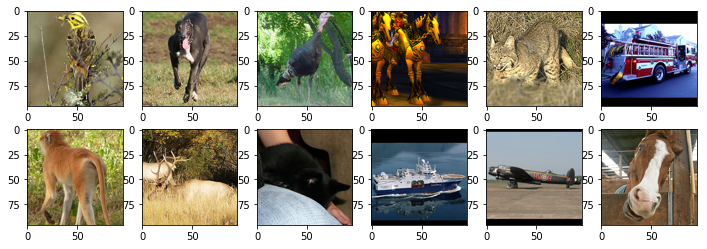

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

for i, ax in enumerate(axs.flat):
  ax.imshow(X_train[i].transpose(1,2,0))
plt.show()

In [12]:
# load STL-10 test data
X_test, y_test = _load_stl10("test")

test images
(8000, 3, 96, 96)
(8000,)


## Test protocol #1 PCA features

In [13]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train.reshape((X_train.shape[0],-1)))

pca = PCA(n_components=config['model']['out_dim'])

X_train_pca = pca.fit_transform(scaler.transform(X_train.reshape(X_train.shape[0], -1)))
X_test_pca = pca.transform(scaler.transform(X_test.reshape(X_test.shape[0], -1)))

print("PCA features")
print(X_train_pca.shape)
print(X_test_pca.shape)

PCA features
(5000, 256)
(8000, 256)


In [14]:
def linear_model_eval(X_train, y_train, X_test, y_test):
    
    clf = LogisticRegression(random_state=0, max_iter=1200, solver='lbfgs', C=1.0)
    clf.fit(X_train, y_train)
    print("Logistic Regression feature eval")
    print("Train score:", clf.score(X_train, y_train))
    print("Test score:", clf.score(X_test, y_test))
    
    print("-------------------------------")
    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train)
    print("KNN feature eval")
    print("Train score:", neigh.score(X_train, y_train))
    print("Test score:", neigh.score(X_test, y_test))

In [15]:
linear_model_eval(X_train_pca, y_train, X_test_pca, y_test)

## clean up resources
del X_train_pca
del X_test_pca

Logistic Regression feature eval
Train score: 0.4956
Test score: 0.347
-------------------------------
KNN feature eval
Train score: 0.4058
Test score: 0.300875


## Protocol #2 Logisitc Regression

In [16]:
# Load the neural net module
spec = importlib.util.spec_from_file_location("model", os.path.join(checkpoints_folder, 'resnet_simclr.py'))
resnet_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(resnet_module)

In [17]:
model = resnet_module.ResNetSimCLR(**config['model'])
model.eval()

state_dict = torch.load(os.path.join(checkpoints_folder, 'model.pth'), map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model = model.to(device)

Feature extractor: resnet18


In [18]:
def next_batch(X, y, batch_size):
    for i in range(0, X.shape[0], batch_size):
        X_batch = torch.tensor(X[i: i+batch_size]) / 255.
        y_batch = torch.tensor(y[i: i+batch_size])
        yield X_batch.to(device), y_batch.to(device)

In [19]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(5000, 512)


In [20]:
X_test_feature = []

for batch_x, batch_y in next_batch(X_test, y_test, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_test_feature.extend(features.cpu().detach().numpy())
    
X_test_feature = np.array(X_test_feature)

print("Test features")
print(X_test_feature.shape)

Test features
(8000, 512)


In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_feature)

linear_model_eval(scaler.transform(X_train_feature), y_train, scaler.transform(X_test_feature), y_test)

del X_train_feature
del X_test_feature

Logistic Regression feature eval
Train score: 0.9506
Test score: 0.729375
-------------------------------
KNN feature eval
Train score: 0.7628
Test score: 0.698375


In [22]:
X_train_feature = []

for batch_x, batch_y in next_batch(X_train, y_train, batch_size=config['batch_size']):
    features, _ = model(batch_x)
    X_train_feature.extend(features.cpu().detach().numpy())
    
X_train_feature = np.array(X_train_feature)

print("Train features")
print(X_train_feature.shape)

Train features
(5000, 512)


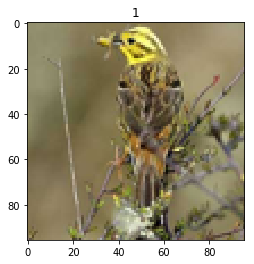

/home/joshua/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


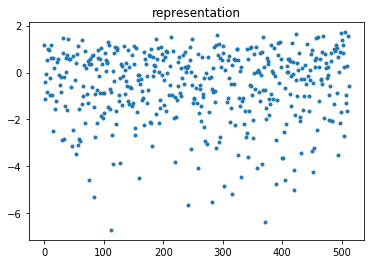

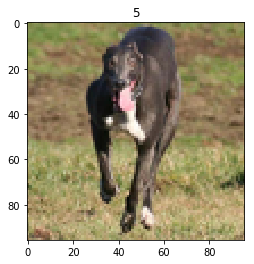

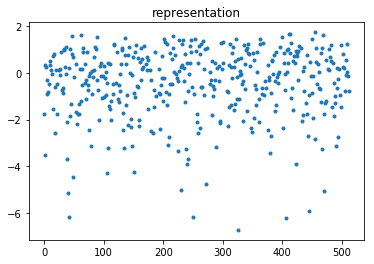

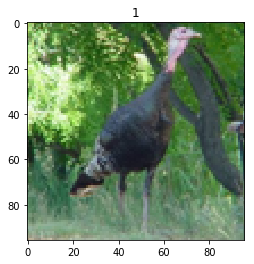

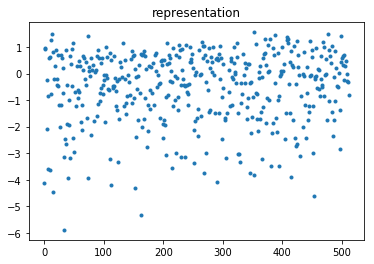

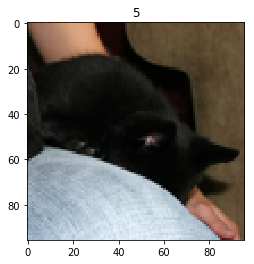

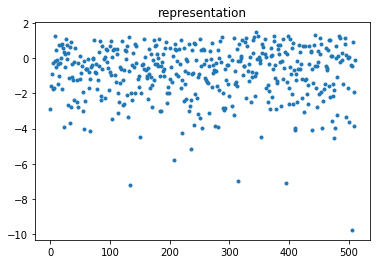

In [37]:
### plotting features and 

for i in range(10):
    
    if y_train[i] == 1 or y_train[i] == 5:
        plt.imshow(X_train[i].transpose(1,2,0))
        plt.title(y_train[i])
        plt.show()

        

        plt.plot(np.log(X_train_feature[i]), '.')
        plt.title("representation")
        plt.show()
        
    

# fig, axs = plt.subplots(nrows=2, ncols=6, constrained_layout=False, figsize=(12,4))

# for i, ax in enumerate(axs.flat):
#   ax.imshow(X_train[i].transpose(1,2,0))
# plt.show()

In [39]:
import umap


embedding = umap.UMAP().fit_transform(X_train_feature)
"umapembed=pd.DataFrame({'labels':labels,'umap0':embedding[:,0],'umap1':embedding[:,1]})\n",
"# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"#                 hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],\n",
"#                 linewidth=0,s=1,palette='viridis', legend='full')\n",
"sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels,\n",
"                linewidth=0,s=3,palette='viridis', legend='full')\n",
"plt.legend(bbox_to_anchor=(0.98, 1))\n",
"plt.show()"

/home/joshua/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


'plt.show()'

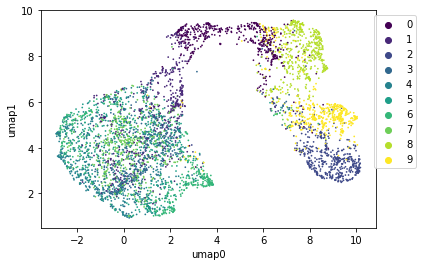

In [45]:
import pandas as pd
import seaborn as sns
umapembed=pd.DataFrame({'labels':y_train,'umap0':embedding[:,0],'umap1':embedding[:,1]})
# sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=labels, hue_order=['-0.94', '-0.5', '0', '0.5', '0.94'],
# linewidth=0,s=1,palette='viridis', legend='full')
sns.scatterplot(x='umap0',y='umap1',data=umapembed, hue=y_train, linewidth=0,s=3,palette='viridis', legend='full')
plt.legend(bbox_to_anchor=(0.98, 1))
plt.show()